In [38]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as ppc
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

In [39]:
df = pd.read_csv(
    "../data/Housing price in Beijing.csv",
    encoding="gbk",
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   url                  318851 non-null  object 
 1   id                   318851 non-null  object 
 2   Lng                  318851 non-null  float64
 3   Lat                  318851 non-null  float64
 4   Cid                  318851 non-null  int64  
 5   tradeTime            318851 non-null  object 
 6   DOM                  160874 non-null  float64
 7   followers            318851 non-null  int64  
 8   totalPrice           318851 non-null  float64
 9   price                318851 non-null  int64  
 10  square               318851 non-null  float64
 11  livingRoom           318851 non-null  object 
 12  drawingRoom          318851 non-null  object 
 13  kitchen              318851 non-null  int64  
 14  bathRoom             318851 non-null  object 
 15  floor            

/var/folders/91/3h5d16fs4kqbxb8yw967rz_h0000gn/T/ipykernel_34352/4010588395.py:1: DtypeWarning: Columns (1,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [40]:
df = df[:10000]

In [41]:
Y = df["price"]
X = df.drop(
    columns=[
        "price",
        "id",
        "url",
        "Lng",
        "Lat",
        "Cid",
        "tradeTime",
        "DOM",
        "followers",
        # "totalPrice",
        # "communityAverage",
    ]
)

In [42]:
X.head(5)

,totalPrice,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,415.0,131.00,2,1,1,1,高 26,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,575.0,132.38,2,2,1,2,高 22,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,1030.0,198.00,3,2,1,3,中 4,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,297.5,134.00,3,1,1,1,底 21,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,392.0,81.00,2,1,1,1,中 6,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   totalPrice           10000 non-null  float64
 1   square               10000 non-null  float64
 2   livingRoom           10000 non-null  object 
 3   drawingRoom          10000 non-null  object 
 4   kitchen              10000 non-null  int64  
 5   bathRoom             10000 non-null  object 
 6   floor                10000 non-null  object 
 7   buildingType         9893 non-null   float64
 8   constructionTime     10000 non-null  object 
 9   renovationCondition  10000 non-null  int64  
 10  buildingStructure    10000 non-null  int64  
 11  ladderRatio          10000 non-null  float64
 12  elevator             10000 non-null  float64
 13  fiveYearsProperty    10000 non-null  float64
 14  subway               10000 non-null  float64
 15  district             10000 non-null  

In [44]:
cols = ["constructionTime", "livingRoom", "drawingRoom", "bathRoom"]

for c in cols:
    X[c] = X[c].astype(str).str.replace(r"[^0-9-]", "", regex=True)
    X[c] = pd.to_numeric(X[c], errors="coerce").astype("Int64")

X[cols].head()

,constructionTime,livingRoom,drawingRoom,bathRoom
0,2005,2,1,1
1,2004,2,2,2
2,2005,3,2,3
3,2008,3,1,1
4,1960,2,1,1


In [45]:
Y.head(5)

0    31680
1    43436
2    52021
3    22202
4    48396
Name: price, dtype: int64

In [46]:
variance = np.var(Y)
std_dev = np.std(Y)

print("Дисперсия:", variance)
print("Стандартное отклонение:", std_dev)

Дисперсия: 503742617.7365406
Стандартное отклонение: 22444.21122999293


In [47]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_cols, cat_cols

(['totalPrice',
  'square',
  'livingRoom',
  'drawingRoom',
  'kitchen',
  'bathRoom',
  'buildingType',
  'constructionTime',
  'renovationCondition',
  'buildingStructure',
  'ladderRatio',
  'elevator',
  'fiveYearsProperty',
  'subway',
  'district',
  'communityAverage'],
 ['floor'])

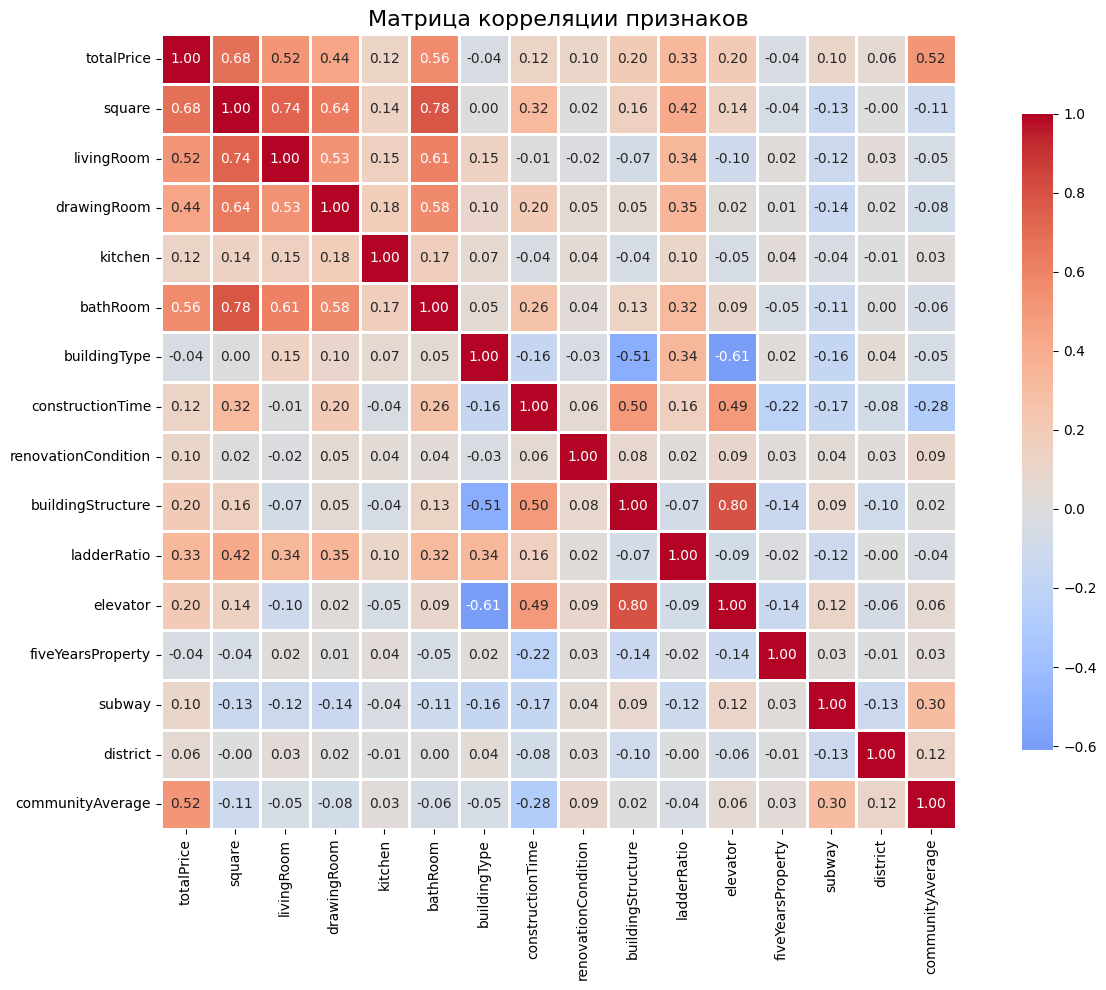

In [48]:
plt.figure(figsize=(14, 10))

correlation_matrix = X.select_dtypes(
    include=["int64", "float64", "Int64"]
).corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
)

plt.title("Матрица корреляции признаков", fontsize=16)
plt.tight_layout()
plt.show()

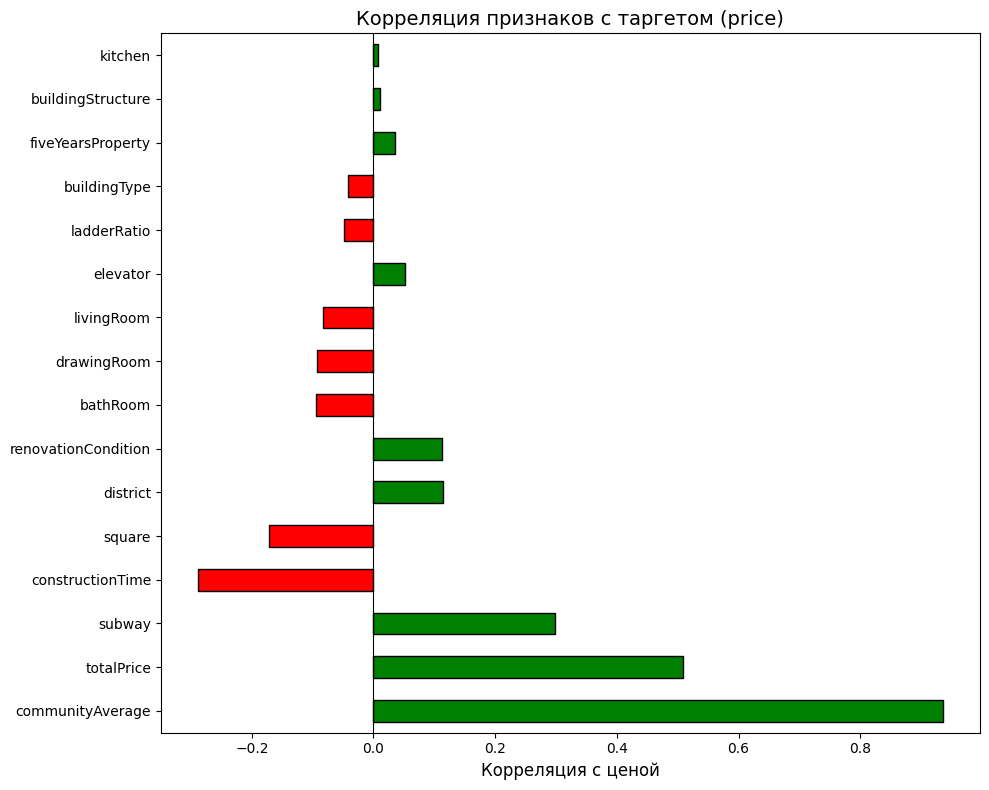


Топ-10 признаков по корреляции с ценой:
communityAverage       0.935509
totalPrice             0.508236
subway                 0.298243
constructionTime      -0.288254
square                -0.172457
district               0.114288
renovationCondition    0.111816
bathRoom              -0.095256
drawingRoom           -0.093589
livingRoom            -0.082686
dtype: float64


In [49]:
correlations_with_target = {}

for col in numeric_cols:
    valid_data = pd.concat([X[col], Y], axis=1).dropna()
    if len(valid_data) > 0:
        correlations_with_target[col] = valid_data[col].corr(
            valid_data["price"]
        )

corr_series = pd.Series(correlations_with_target).sort_values(
    key=abs, ascending=False
)

plt.figure(figsize=(10, 8))
colors = ["red" if x < 0 else "green" for x in corr_series.values]
corr_series.plot(kind="barh", color=colors, edgecolor="black")
plt.axvline(x=0, color="black", linestyle="-", linewidth=0.8)
plt.xlabel("Корреляция с ценой", fontsize=12)
plt.title("Корреляция признаков с таргетом (price)", fontsize=14)
plt.tight_layout()
plt.show()

print("\nТоп-10 признаков по корреляции с ценой:")
print(corr_series.head(10))

In [50]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", ppc.StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            ppc.OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False,
            ),
        )
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.3,
    random_state=69,
)

In [52]:
class CustomAnalLinReg(BaseEstimator, RegressorMixin):
    """
    Линейная регрессия с аналитическим решением.
    Использует псевдообратную матрицу для решения w = pinv(X) @ y
    """

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
    ):
        self.weights_ = np.linalg.pinv(X) @ y
        self.bias_ = np.mean(y) - np.mean(X, axis=0) @ self.weights_
        return self

    def predict(
        self,
        X: np.ndarray,
    ) -> np.ndarray:
        return X @ self.weights_ + self.bias_

In [53]:
models = {
    "Custom LinReg": CustomAnalLinReg(),
    "Linear Regression": LinearRegression(),
    "Ridge (α=1.0)": Ridge(alpha=1.0),
    "Lasso (α=1.0)": Lasso(
        alpha=1.0,
        max_iter=10000,
    ),
    "ElasticNet": ElasticNet(
        alpha=1.0,
        l1_ratio=0.5,
        max_iter=10000,
    ),
    "Decision Tree": DecisionTreeRegressor(
        max_depth=10,
        random_state=42,
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        random_state=42,
    ),
    "KNN (k=5)": KNeighborsRegressor(
        n_neighbors=5,
    ),
}

In [54]:
results = {}

for name, model in models.items():
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", model),
        ]
    )

    pipeline.fit(X_train, y_train)

    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    results[name] = {
        "R2 (train)": r2_score(y_train, y_pred_train),
        "R2 (test)": r2_score(y_test, y_pred_test),
        "RMSE (train)": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "RMSE (test)": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "MAE (train)": mean_absolute_error(y_train, y_pred_train),
        "MAE (test)": mean_absolute_error(y_test, y_pred_test),
        "predictions": y_pred_test,
    }

    print(f"\n{name}:")
    print(f"  R2 (train): {results[name]['R2 (train)']:.4f}")
    print(f"  R2 (test):  {results[name]['R2 (test)']:.4f}")
    print(f"  RMSE (test): {results[name]['RMSE (test)']:.2f}")
    print(f"  MAE (test):  {results[name]['MAE (test)']:.2f}")

results_df = pd.DataFrame(results).T
print("\n" + "=" * 60)
print("Сводная таблица результатов:")
print(results_df.drop(columns=["predictions"]))


Custom LinReg:
  R2 (train): 0.9194
  R2 (test):  0.9036
  RMSE (test): 7220.22
  MAE (test):  4907.94

Linear Regression:
  R2 (train): 0.9194
  R2 (test):  0.9052
  RMSE (test): 7157.62
  MAE (test):  4890.99

Ridge (α=1.0):
  R2 (train): 0.9192
  R2 (test):  0.9065
  RMSE (test): 7109.49
  MAE (test):  4877.92

Lasso (α=1.0):
  R2 (train): 0.9193
  R2 (test):  0.9059
  RMSE (test): 7131.80
  MAE (test):  4868.82

ElasticNet:
  R2 (train): 0.8367
  R2 (test):  0.8241
  RMSE (test): 9751.38
  MAE (test):  7188.90

Decision Tree:
  R2 (train): 0.9565
  R2 (test):  0.9144
  RMSE (test): 6802.63
  MAE (test):  4462.31

Random Forest:
  R2 (train): 0.9729
  R2 (test):  0.9386
  RMSE (test): 5759.94
  MAE (test):  3698.52

Gradient Boosting:
  R2 (train): 0.9920
  R2 (test):  0.9770
  RMSE (test): 3524.69
  MAE (test):  2284.03

KNN (k=5):
  R2 (train): 0.8979
  R2 (test):  0.8402
  RMSE (test): 9293.06
  MAE (test):  6744.24

Сводная таблица результатов:
                  R2 (train) R2 (

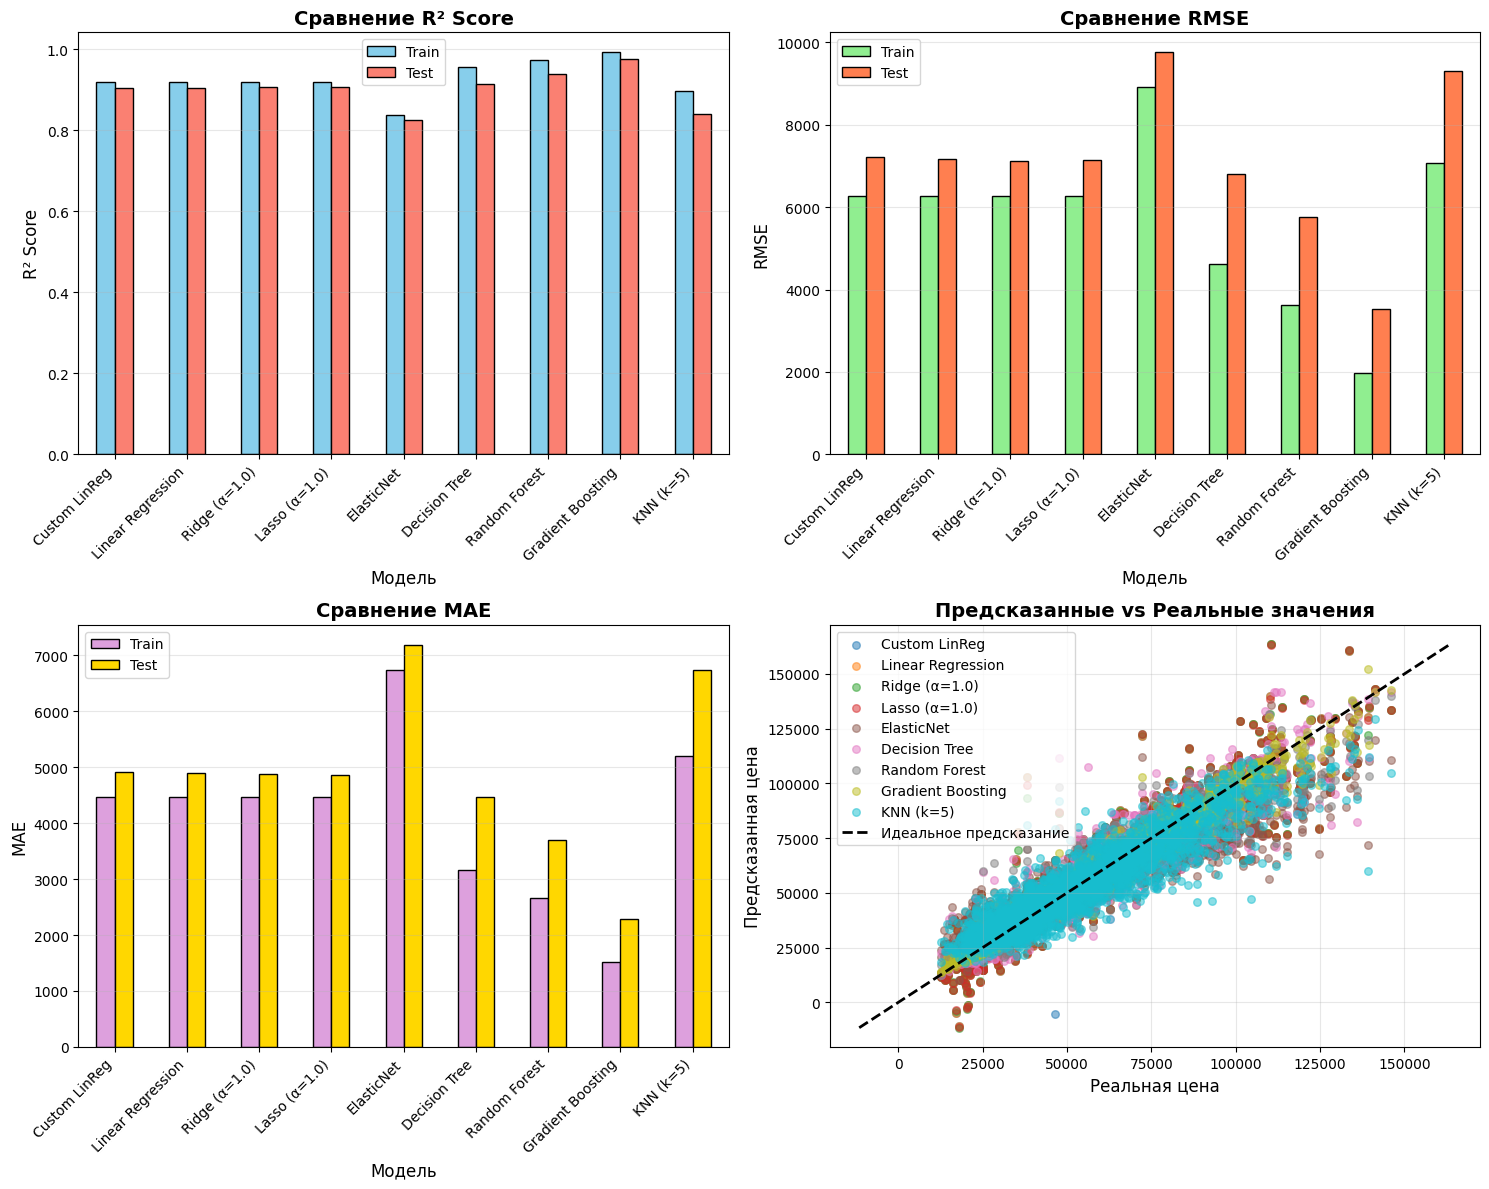

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

ax1 = axes[0, 0]
r2_data = results_df[["R2 (train)", "R2 (test)"]]
r2_data.plot(
    kind="bar", ax=ax1, color=["skyblue", "salmon"], edgecolor="black"
)
ax1.set_title("Сравнение R² Score", fontsize=14, fontweight="bold")
ax1.set_ylabel("R² Score", fontsize=12)
ax1.set_xlabel("Модель", fontsize=12)
ax1.legend(["Train", "Test"])
ax1.grid(axis="y", alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


ax2 = axes[0, 1]
rmse_data = results_df[["RMSE (train)", "RMSE (test)"]]
rmse_data.plot(
    kind="bar", ax=ax2, color=["lightgreen", "coral"], edgecolor="black"
)
ax2.set_title("Сравнение RMSE", fontsize=14, fontweight="bold")
ax2.set_ylabel("RMSE", fontsize=12)
ax2.set_xlabel("Модель", fontsize=12)
ax2.legend(["Train", "Test"])
ax2.grid(axis="y", alpha=0.3)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")


ax3 = axes[1, 0]
mae_data = results_df[["MAE (train)", "MAE (test)"]]
mae_data.plot(kind="bar", ax=ax3, color=["plum", "gold"], edgecolor="black")
ax3.set_title("Сравнение MAE", fontsize=14, fontweight="bold")
ax3.set_ylabel("MAE", fontsize=12)
ax3.set_xlabel("Модель", fontsize=12)
ax3.legend(["Train", "Test"])
ax3.grid(axis="y", alpha=0.3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha="right")

ax4 = axes[1, 1]

colors_scatter = cm.tab10(np.linspace(0, 1, len(results)))
for idx, (name, data) in enumerate(results.items()):
    ax4.scatter(
        y_test,
        data["predictions"],
        alpha=0.5,
        s=30,
        label=name,
        color=colors_scatter[idx],
    )

min_val = min(
    y_test.min(), min([r["predictions"].min() for r in results.values()])
)
max_val = max(
    y_test.max(), max([r["predictions"].max() for r in results.values()])
)
ax4.plot(
    [min_val, max_val],
    [min_val, max_val],
    "k--",
    lw=2,
    label="Идеальное предсказание",
)

ax4.set_title(
    "Предсказанные vs Реальные значения", fontsize=14, fontweight="bold"
)
ax4.set_xlabel("Реальная цена", fontsize=12)
ax4.set_ylabel("Предсказанная цена", fontsize=12)
ax4.legend()
ax4.grid(alpha=0.3)


plt.tight_layout()
plt.show()